## previous_application.csv table 

###  A brief examination of the prior applications with a description of each column 

***


## Load and read data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
from collections import Counter

import matplotlib.pyplot as plt

from sklearn.preprocessing import (
    OneHotEncoder, 
    KBinsDiscretizer, 
    FunctionTransformer,
    MinMaxScaler,
)

from sklearn.compose import ColumnTransformer

In [2]:
#Read the data into pandas dataframe
df = pd.read_csv('previous_application.csv')

In [3]:
df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Understanding data

In [4]:
# displaying columns
df.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [5]:
# How large is my dataset?
print(f"My dataset has {df.shape[0]} rows and {df.shape[1]} columns")


My dataset has 1670214 rows and 37 columns


In [6]:
## We now want to check out our data-types as well as get a feeling for possible missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

#### Generally we assume the data is incomplete (has missing values) and is incorrect (has obvious logical problems that defy our understanding of the content)

## Explore and clean data


##### Drop columns


Since we are not interested in all the columns, we can drop some of these to make our exploration easier

In [7]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]
# Let's use above function to look at top ten columns with NaNs
calc_percent_NAs(df).head(15)

,percent
RATE_INTEREST_PRIVILEGED,0.996437
RATE_INTEREST_PRIMARY,0.996437
AMT_DOWN_PAYMENT,0.536365
RATE_DOWN_PAYMENT,0.536365
NAME_TYPE_SUITE,0.491198
NFLAG_INSURED_ON_APPROVAL,0.402981
DAYS_TERMINATION,0.402981
DAYS_LAST_DUE,0.402981
DAYS_LAST_DUE_1ST_VERSION,0.402981
DAYS_FIRST_DUE,0.402981


Dropping columns with > 40 % of missing values (11 columns) :
<br>
RATE_INTEREST_PRIVILEGED, RATE_INTEREST_PRIMARY, AMT_DOWN_PAYMENT,  RATE_DOWN_PAYMENT, NAME_TYPE_SUITE, NFLAG_INSURED_ON_APPROVAL, DAYS_TERMINATION, DAYS_LAST_DUE, DAYS_LAST_DUE_1ST_VERSION,  DAYS_FIRST_DUE, DAYS_FIRST_DRAWING 

In [8]:
#drop columns with > 40% NaNs
df.drop(['RATE_INTEREST_PRIVILEGED', 'RATE_INTEREST_PRIMARY', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_TERMINATION', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DUE', 'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE'], axis = 1, inplace=True)

In [9]:
# How large is my dataset?
print(f"My dataset has {df.shape[0]} rows and {df.shape[1]} columns")

My dataset has 1670214 rows and 26 columns


In [10]:
#drop irrelevant columns 
df.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis = 1, inplace=True)

In [11]:
df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,Y,1,XAP,...,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,Y,1,XNA,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,Y,1,Repairs,...,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high


### Columns of the data 

**Variable Description:**

|Variable|Definition |Key|  Type |
|---|---|---|---|
| **SK_ID_PREV** | ID of previous credit in Home credit related to loan in our sample | |int| 
|**NAME_CONTRACT_TYPE**|Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application | |object|
|**AMT_ANNUITY**|Annuity of previous application| | float|
|**AMT_APPLICATION**|For how much credit did client ask on the previous application| | float|
|**AMT_CREDIT**|Final credit amount on the previous application. | | float|
|**AMT_GOODS_PRICE**|Goods price of good that client asked for (if applicable) on the previous application | | float|
|**WEEKDAY_APPR_PROCESS_START**|On which day of the week did the client apply for previous application| |object|
|**HOUR_APPR_PROCESS_START**|Approximately at what day hour did the client apply for the previous application| |int|
|**FLAG_LAST_APPL_PER_CONTRACT**|Flag if it was last application for the previous contract.| |object|
|**NFLAG_LAST_APPL_IN_DAY**|Flag if the application was the last application per day of the client | |int| 
|**NAME_CASH_LOAN_PURPOSE** | Purpose of the cash loan| |object| 
|**NAME_CONTRACT_STATUS**|Contract status (approved, cancelled, ...) of previous application | |object|
|**DAYS_DECISION**|Relative to current application when was the decision about previous application made| |int|
|**NAME_PAYMENT_TYPE**|Payment method that client chose to pay for the previous application| |object|
|**CODE_REJECT_REASON**|Why was the previous application rejected | |object|
|**NAME_CLIENT_TYPE**|Was the client old or new client when applying for the previous application| |object|
|**NAME_GOODS_CATEGORY**|What kind of goods did the client apply for in the previous application| |object|
|**NAME_PORTFOLIO**|Was the previous application for CASH, POS, CAR | |object|
|**NAME_PRODUCT_TYPE**| Was the previous application x-sell o walk-in| |object|
|**CHANNEL_TYPE**|Through which channel we acquired the client on the previous application| |object|
|**SELLERPLACE_AREA**|Selling area of seller place of the previous application| |int|
|**NAME_SELLER_INDUSTRY**|The industry of the seller| |object|
|**CNT_PAYMENT**|Term of previous credit at application of the previous application| |float|
|**NAME_YIELD_GROUP**|Grouped interest rate into small medium and high of the previous application | |object|
|**PRODUCT_COMBINATION**|Detailed product combination of the previous application| |object|
|**DAYS_LAST_DUE**|Relative to application date of current application when was the last due date of the previous appl| |float|


#### Deal with duplicate rows


In [13]:
# check for duplicate rows in video_id column
df["SK_ID_CURR"].duplicated().value_counts()

True     1331357
False     338857
Name: SK_ID_CURR, dtype: int64

In [14]:
### indentifying duplicate rows if any
df[df.duplicated()].shape

(0, 24)

In [15]:
## CODE_REJECT_REASON, NAME_CONTRACT_TYPE, NAME_CASH_LOAN_PURPOSESK_

In [16]:
print(df.SK_ID_PREV.nunique())
print(df.SK_ID_CURR.nunique())

1670214
338857


Number of rows: 1670214
<br>
Number of unique previous applications (SK_ID_PREV): 1670214
<br>
Number of unique current applications (SK_ID_CURR): 338857

In [17]:
df = df.drop_duplicates(subset=['SK_ID_CURR'])

In [18]:
print(df.SK_ID_PREV.nunique())
print(df.SK_ID_CURR.nunique())

338857
338857


#### Descriptive Statistics


In [19]:
df_mean = df.groupby(['SK_ID_PREV', 'SK_ID_CURR']).mean() [:]

In [20]:
df_mean

,,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT
SK_ID_PREV,SK_ID_CURR,,,,,,,,
1000001,158271,6404.310,58905.000,65124.00,58905.000,1.0,-299.0,70.0,12.0
1000002,101962,6264.000,39145.500,35230.50,39145.500,1.0,-1634.0,1780.0,6.0
1000005,176456,14713.605,123486.075,120307.50,123486.075,1.0,-1719.0,1877.0,10.0
1000009,343078,9302.850,42705.000,45243.00,42705.000,1.0,-488.0,121.0,6.0
1000016,157990,6078.150,63720.000,56970.00,63720.000,1.0,-717.0,185.0,12.0
...,...,...,...,...,...,...,...,...,...
2845367,330376,15302.205,180000.000,186840.00,180000.000,1.0,-1491.0,49.0,18.0
2845370,127124,NaN,34159.140,34159.14,34159.140,1.0,-1930.0,2005.0,NaN
2845377,250234,5009.400,108180.000,108180.00,108180.000,1.0,-1030.0,150.0,24.0


In [21]:
#Let's have a look at our numerical variables and their descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,338857.0,1.914716e+06,534143.930627,1000001.0,1449163.00,1.911829e+06,2.378179e+06,2845382.000
SK_ID_CURR,338857.0,2.781499e+05,102879.193103,100001.0,189061.00,2.782210e+05,3.673020e+05,456255.000
AMT_ANNUITY,287762.0,1.423110e+04,13381.062510,0.0,5899.14,1.012142e+04,1.746134e+04,417927.645
AMT_APPLICATION,338857.0,1.528646e+05,247731.912944,0.0,30600.00,7.513200e+04,1.575000e+05,5850000.000
AMT_CREDIT,338857.0,1.683748e+05,268680.949496,0.0,33579.00,8.092800e+04,1.751895e+05,4104351.000
AMT_GOODS_PRICE,284907.0,1.818291e+05,260271.882309,0.0,47205.00,9.386550e+04,1.845000e+05,5850000.000
NFLAG_LAST_APPL_IN_DAY,338857.0,9.976067e-01,0.048863,0.0,1.00,1.000000e+00,1.000000e+00,1.000
DAYS_DECISION,338857.0,-9.267309e+02,784.705424,-2922.0,-1371.00,-6.410000e+02,-3.180000e+02,-2.000
SELLERPLACE_AREA,338857.0,4.358585e+02,13890.023521,-1.0,-1.00,3.000000e+01,1.480000e+02,4000000.000
CNT_PAYMENT,287765.0,1.405768e+01,12.129195,0.0,6.00,1.200000e+01,1.800000e+01,72.000


In [22]:
* Days od decision
* AMT_Annuity
* AMT_CREDIT

SyntaxError: invalid syntax (1050038224.py, line 1)

#### Missing values

In [23]:
df.isna().sum()

SK_ID_PREV                         0
SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
AMT_ANNUITY                    51095
AMT_APPLICATION                    0
AMT_CREDIT                         0
AMT_GOODS_PRICE                53950
FLAG_LAST_APPL_PER_CONTRACT        0
NFLAG_LAST_APPL_IN_DAY             0
NAME_CASH_LOAN_PURPOSE             0
NAME_CONTRACT_STATUS               0
DAYS_DECISION                      0
NAME_PAYMENT_TYPE                  0
CODE_REJECT_REASON                 0
NAME_CLIENT_TYPE                   0
NAME_GOODS_CATEGORY                0
NAME_PORTFOLIO                     0
NAME_PRODUCT_TYPE                  0
CHANNEL_TYPE                       0
SELLERPLACE_AREA                   0
NAME_SELLER_INDUSTRY               0
CNT_PAYMENT                    51092
NAME_YIELD_GROUP                   0
PRODUCT_COMBINATION               52
dtype: int64

Missing values in:
<br>
AMT_ANNUITY
<br>
AMT_GOODS_PRICE
<br>
CNT_PAYMENT
<br>
PRODUCT_COMBINATION

In [24]:
#imputate missing values with mean
df['AMT_ANNUITY']=df['AMT_ANNUITY'].fillna(df['AMT_ANNUITY'].mean())
df['AMT_GOODS_PRICE']=df['AMT_GOODS_PRICE'].fillna(df['AMT_GOODS_PRICE'].mean())


In [25]:
#imputate the NaNs with most common value 
df.PRODUCT_COMBINATION.mode()[0]

'POS household with interest'

In [26]:
df["PRODUCT_COMBINATION"].fillna(df["PRODUCT_COMBINATION"].mode()[0],inplace=True)

<AxesSubplot:>

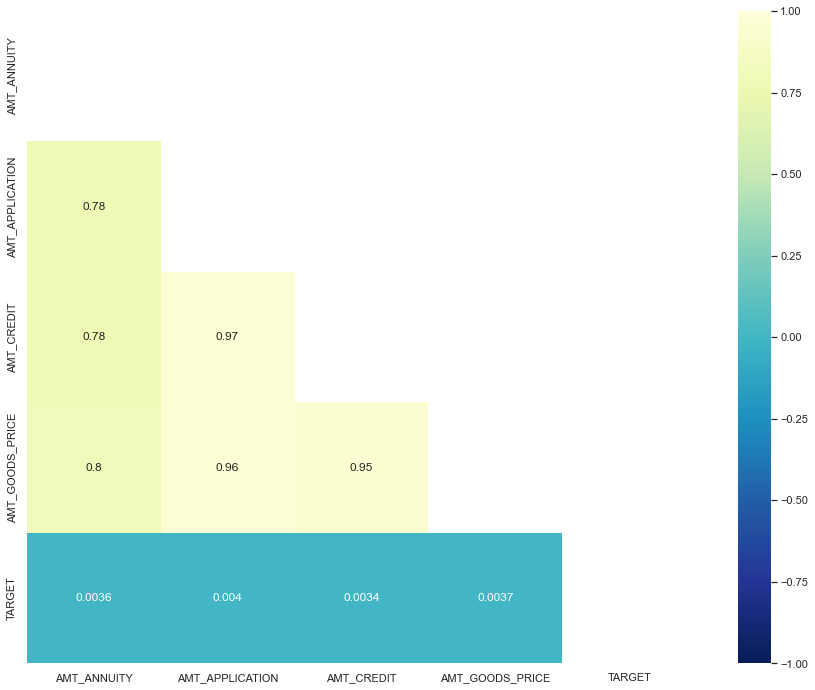

In [93]:
corr = df.corr()
plt.subplots(figsize=(15, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap="YlGnBu_r", mask=mask, vmax=1, vmin=-1)

Assuming that AMT ANNUITY and CNT PAYMENT are highly connected given that CNT PAYMENT may be completely described by AMT ANNUITY, I will remove the CNT PAYMENT feature

In [27]:
df.drop(columns=['CNT_PAYMENT'], inplace=True) #we can repcase with AMT_ANNUITY high correlaton 

In [28]:
df.isna().sum()

SK_ID_PREV                     0
SK_ID_CURR                     0
NAME_CONTRACT_TYPE             0
AMT_ANNUITY                    0
AMT_APPLICATION                0
AMT_CREDIT                     0
AMT_GOODS_PRICE                0
FLAG_LAST_APPL_PER_CONTRACT    0
NFLAG_LAST_APPL_IN_DAY         0
NAME_CASH_LOAN_PURPOSE         0
NAME_CONTRACT_STATUS           0
DAYS_DECISION                  0
NAME_PAYMENT_TYPE              0
CODE_REJECT_REASON             0
NAME_CLIENT_TYPE               0
NAME_GOODS_CATEGORY            0
NAME_PORTFOLIO                 0
NAME_PRODUCT_TYPE              0
CHANNEL_TYPE                   0
SELLERPLACE_AREA               0
NAME_SELLER_INDUSTRY           0
NAME_YIELD_GROUP               0
PRODUCT_COMBINATION            0
dtype: int64

In [29]:
print(f"My dataset has {df.shape[0]} rows and {df.shape[1]} columns")

My dataset has 338857 rows and 23 columns


#### Outliers

We see in our descriptive statistics, that the minimum and maximum values in our numerical columns are far apart from each other. Let's have a look at these "extreme" values by looking at boxplots

In [30]:
num_col = df.describe().columns

In [31]:
### converting days columns with negative value to positive to make plotting and calculations easy 
df["DAYS_DECISION"] = df["DAYS_DECISION"].abs()

Box Plot for  SK_ID_PREV


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


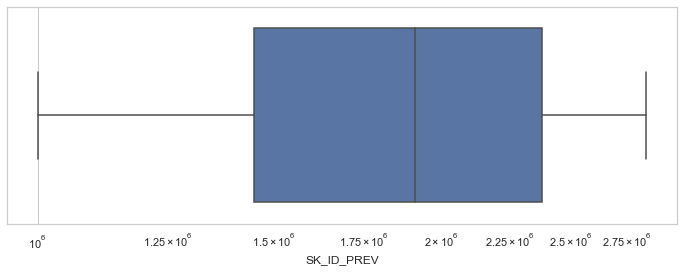


Box Plot for  SK_ID_CURR


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


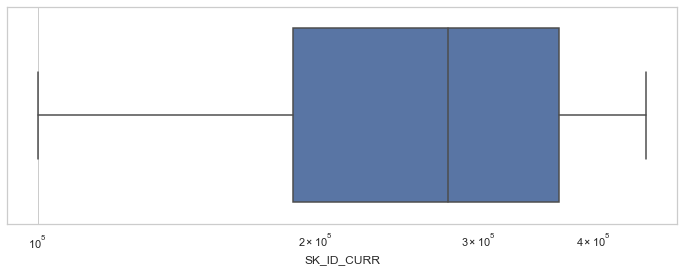


Box Plot for  AMT_ANNUITY


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


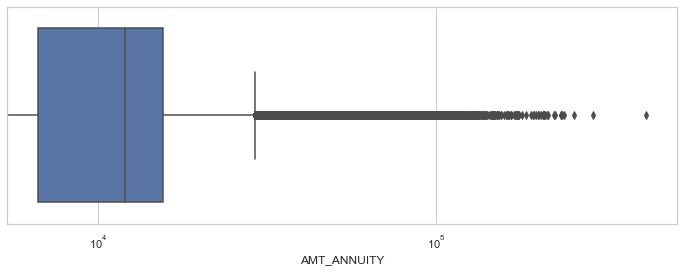


Box Plot for  AMT_APPLICATION


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


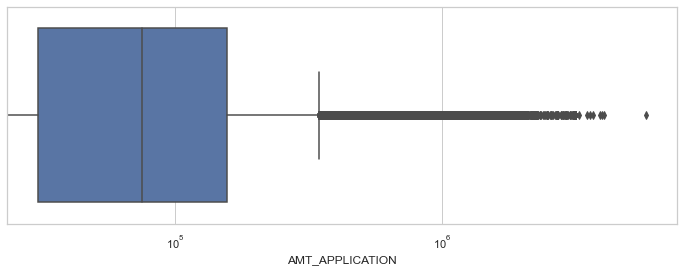


Box Plot for  AMT_CREDIT


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


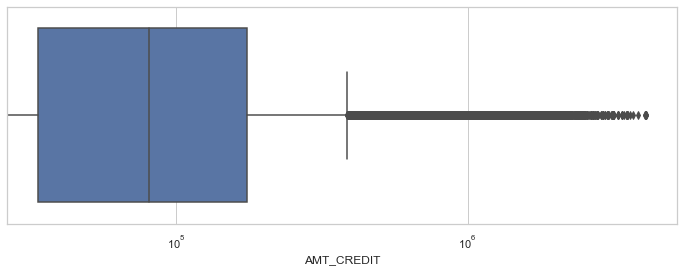


Box Plot for  AMT_GOODS_PRICE


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


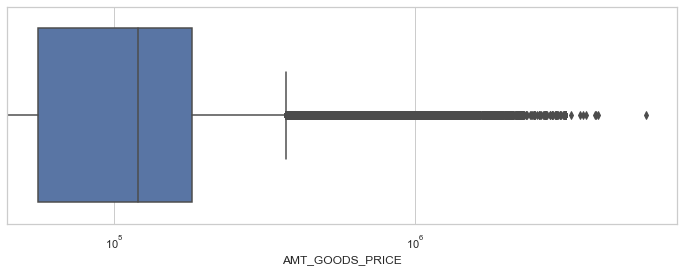


Box Plot for  NFLAG_LAST_APPL_IN_DAY


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


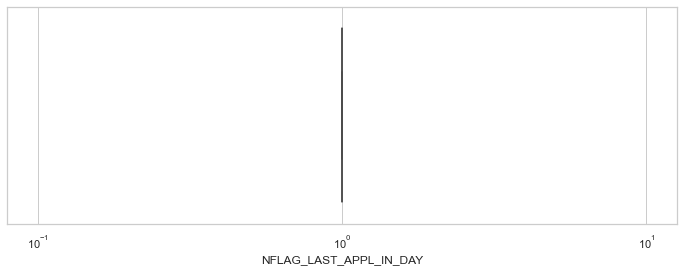


Box Plot for  DAYS_DECISION


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


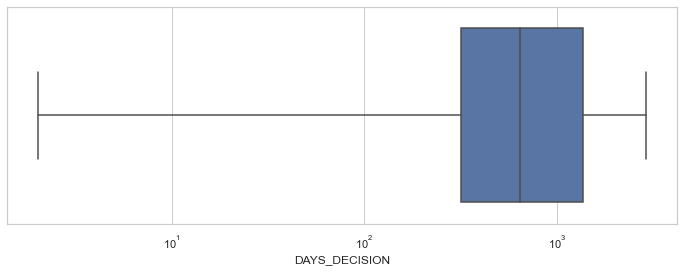


Box Plot for  SELLERPLACE_AREA


C:\Users\Sey\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


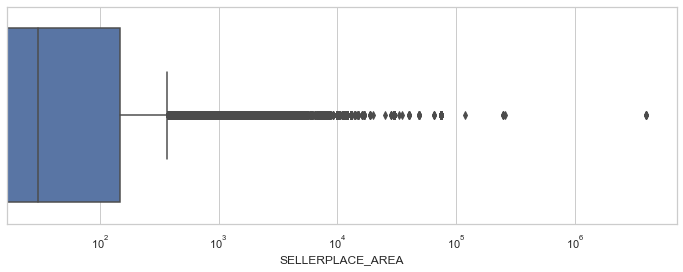

In [32]:
##### Plotting box plots for all numerical columns 
for col in num_col:
    print('Box Plot for ',col)
    plt.figure(figsize=[12,4])
    sns.set(style='whitegrid')
    plt.xscale('log')
    sns.boxplot(data =df, x=col,orient='v')
    plt.show()
    print()

def plot_hist(var):
    plt.figure(figsize=(15,5))
    plt.hist(df[var], bins=50)
    plt.xticks(rotation=90)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(var))
    plt.show()
    
for n in df:
    plot_hist(n)

In [95]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [96]:
outliers = find_outliers_IQR(df[['AMT_ANNUITY']])

print("number of outliers:" + str(len(outliers)))

print("max outlier value:" + str(outliers.max()))

print("min outlier value:" + str(outliers.min()))

print(outliers.dropna().reset_index())
outliers

number of outliers:449105
max outlier value:AMT_ANNUITY    1.0
dtype: float64
min outlier value:AMT_ANNUITY    0.069534
dtype: float64
        index  AMT_ANNUITY
0      100003     0.235345
1      100053     0.069988
2      100069     0.072200
3      100071     0.144258
4      100073     0.094384
...       ...          ...
30233  456207     0.086371
30234  456213     0.075111
30235  456216     0.096714
30236  456218     0.105417
30237  456226     0.144669

[30238 rows x 2 columns]


,AMT_ANNUITY
100001,NaN
100002,NaN
100003,0.235345
100004,NaN
100005,NaN
...,...
307409,NaN
307453,NaN
307472,NaN
307487,NaN


In [97]:
df.loc[outliers.dropna().reset_index()['index']].describe().T


,count,mean,std,min,25%,50%,75%,max
AMT_ANNUITY,30238.0,0.107350,0.041033,0.069534,0.080502,0.095660,0.119719,1.0
AMT_APPLICATION,30238.0,0.121562,0.079035,0.000000,0.061538,0.115385,0.160000,1.0
AMT_CREDIT,30238.0,0.190543,0.117647,0.020086,0.101568,0.172926,0.256989,1.0
AMT_GOODS_PRICE,30238.0,0.122448,0.077858,0.000000,0.061538,0.115385,0.160000,1.0
TARGET,17456.0,0.083868,0.277198,0.000000,0.000000,0.000000,0.000000,1.0


In [99]:
#check = df.loc[outliers.dropna().reset_index()['index']]


<AxesSubplot:xlabel='AMT_ANNUITY', ylabel='TARGET'>

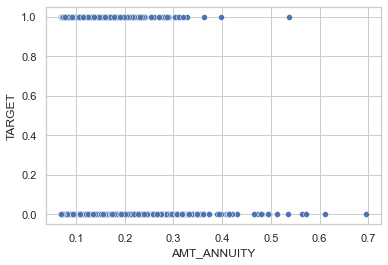

In [101]:
#sns.scatterplot(x=check.AMT_ANNUITY, y=check.TARGET) 

#### Feature Engineering 

In [34]:
## understanding the column meaning & values and checking the datatype for numerical and categorical
for i in df.columns:
    print(df[i].value_counts().head(10),"\n\n")

2030495    1
2048675    1
1036322    1
1259959    1
1593744    1
2156354    1
1497056    1
1517597    1
2031258    1
1698169    1
Name: SK_ID_PREV, dtype: int64 


271877    1
411338    1
127932    1
140605    1
218151    1
143375    1
446383    1
425144    1
372241    1
222277    1
Name: SK_ID_CURR, dtype: int64 


Consumer loans     199628
Cash loans         105751
Revolving loans     33426
XNA                    52
Name: NAME_CONTRACT_TYPE, dtype: int64 


14231.100868    51095
2250.000000      6723
9000.000000      2381
6750.000000      2365
11250.000000     2266
4500.000000      1959
22500.000000     1928
13500.000000     1144
3375.000000       970
7875.000000       836
Name: AMT_ANNUITY, dtype: int64 


0.0         54965
45000.0      9205
225000.0     7191
135000.0     6738
450000.0     5984
90000.0      4969
180000.0     3941
270000.0     3206
675000.0     3153
67500.0      2699
Name: AMT_APPLICATION, dtype: int64 


0.0         44546
45000.0      7242
225000.0     3468
135000.0


### Some columns have values with XNA and XPA instead of NaN
----
----

In [35]:
df.columns.tolist()

['SK_ID_PREV',
 'SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NFLAG_LAST_APPL_IN_DAY',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'DAYS_DECISION',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'SELLERPLACE_AREA',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

#### Investigating NAME_YIELD_GROUP

In [36]:
df.NAME_YIELD_GROUP.value_counts(normalize=True)*100

middle        25.723830
high          23.442042
XNA           22.886941
low_normal    21.034832
low_action     6.912355
Name: NAME_YIELD_GROUP, dtype: float64

In [37]:
# more than 22 % value have XNA data in NAME_YIELD_GROUP column, we can drop this column
df.drop(columns=['NAME_YIELD_GROUP'], inplace=True)

#### Investigating NAME_SELLER_INDUSTRY


In [38]:
df.NAME_SELLER_INDUSTRY.value_counts(normalize=True)*100

XNA                     36.131465
Consumer electronics    30.399549
Connectivity            20.857766
Furniture                5.075297
Construction             2.649200
Clothing                 2.238112
Industry                 1.759149
Auto technology          0.486341
Jewelry                  0.248778
MLM partners             0.106535
Tourism                  0.047808
Name: NAME_SELLER_INDUSTRY, dtype: float64

In [39]:
# more than 35 % value have XNA data, we can drop this column
df.drop(columns=['NAME_SELLER_INDUSTRY'], inplace=True) 

#### Investigating NAME_PORTFOLIO

In [40]:
df.NAME_PORTFOLIO.value_counts(normalize=True)*100

POS      56.835479
Cash     20.245413
XNA      15.077747
Cards     7.809194
Cars      0.032167
Name: NAME_PORTFOLIO, dtype: float64

In [41]:
# 15 % value have XNA data, we can drop this column
df.drop(columns='NAME_PORTFOLIO', inplace=True)

#### Investigating NAME_GOODS_CATEGORY

In [42]:
df.NAME_GOODS_CATEGORY.value_counts(normalize=True)*100

XNA                         41.545844
Mobile                      17.462528
Consumer Electronics         9.748655
Computers                    8.633730
Audio/Video                  7.859067
Furniture                    4.755989
Clothing and Accessories     2.223947
Construction Materials       2.207126
Photo / Cinema Equipment     1.831156
Auto Accessories             0.620616
Jewelry                      0.534739
Homewares                    0.487521
Medical Supplies             0.458896
Vehicles                     0.321670
Sport and Leisure            0.260287
Gardening                    0.232842
Medicine                     0.190051
Other                        0.176476
Tourism                      0.172344
Office Appliances            0.166147
Direct Sales                 0.047218
Fitness                      0.028921
Education                    0.014165
Additional Service           0.009148
Weapon                       0.005902
Insurance                    0.004722
Animals     

In [43]:
# more than 40 % value have XNA data, we can drop this column 
df.drop(columns=['NAME_GOODS_CATEGORY'], inplace=True)  

#### Investigating NAME_CLIENT_TYPE

In [44]:
df.NAME_CLIENT_TYPE.value_counts(normalize=True)*100

Repeater     54.771777
New          35.066119
Refreshed    10.062357
XNA           0.099747
Name: NAME_CLIENT_TYPE, dtype: float64

In [45]:
#XNA is very low but it could be replaced
df.NAME_CLIENT_TYPE.mode()[0]

'Repeater'

In [46]:
df.NAME_CLIENT_TYPE.replace('XNA',df.NAME_CLIENT_TYPE.mode()[0], inplace=True)

#### Investigating CODE_REJECT_REASON

In [47]:
df.CODE_REJECT_REASON.value_counts(normalize=True)*100

XAP       87.478789
HC         5.928459
LIMIT      2.514040
SCO        1.642286
CLIENT     1.508011
SCOFR      0.545953
XNA        0.205987
VERIF      0.146965
SYSTEM     0.029511
Name: CODE_REJECT_REASON, dtype: float64

In [48]:
#XAP is 80% - drop
df.drop(columns=['CODE_REJECT_REASON'], inplace=True) 

#### Investigating NAME_PAYMENT_TYPE

In [49]:
df.NAME_PAYMENT_TYPE.value_counts(normalize=True)*100

Cash through the bank                        68.294295
XNA                                          31.030789
Non-cash from your account                    0.602024
Cashless from the account of the employer     0.072892
Name: NAME_PAYMENT_TYPE, dtype: float64

In [50]:
##XNA is 30% - drop
df.drop(columns=['NAME_PAYMENT_TYPE'], inplace=True)

#### Investigating NAME_CONTRACT_TYPE

In [51]:
df.NAME_CONTRACT_TYPE.value_counts(normalize=True)*100

Consumer loans     58.912166
Cash loans         31.208150
Revolving loans     9.864338
XNA                 0.015346
Name: NAME_CONTRACT_TYPE, dtype: float64

In [52]:
df.NAME_CONTRACT_TYPE.mode()[0]


'Consumer loans'

In [53]:
df.NAME_CONTRACT_TYPE.replace('XNA',df.NAME_CONTRACT_TYPE.mode()[0], inplace=True)

#### Investigating NAME_CASH_LOAN_PURPOSE

In [54]:
df.NAME_CASH_LOAN_PURPOSE.value_counts(normalize=True)*100

XAP                                 68.791850
XNA                                 27.888460
Repairs                              1.109022
Other                                0.735709
Urgent needs                         0.443550
Buying a used car                    0.133094
Everyday expenses                    0.119224
Medicine                             0.113912
Building a house or an annex         0.110076
Education                            0.075548
Journey                              0.062268
Payments on other loans              0.060497
Purchase of electronic equipment     0.058727
Wedding / gift / holiday             0.051939
Furniture                            0.046332
Car repairs                          0.046037
Buying a new car                     0.041906
Buying a home                        0.039545
Buying a holiday home / land         0.024789
Business development                 0.019477
Gasification / water supply          0.018002
Buying a garage                   

In [55]:
df.drop(columns=['NAME_CASH_LOAN_PURPOSE'], inplace=True)

#### Investigating FLAG_LAST_APPL_PER_CONTRACT and NFLAG_LAST_APPL_IN_DAY

In [56]:
df.FLAG_LAST_APPL_PER_CONTRACT.value_counts(normalize=True)*100

Y    99.70312
N     0.29688
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: float64

In [57]:
df.NFLAG_LAST_APPL_IN_DAY.value_counts(normalize=True)*100

1    99.760666
0     0.239334
Name: NFLAG_LAST_APPL_IN_DAY, dtype: float64

Since the both FLAGS are almost 100% yes - we don't need them 

In [58]:
df.drop(columns=['FLAG_LAST_APPL_PER_CONTRACT'], inplace=True) 
df.drop(columns=['NFLAG_LAST_APPL_IN_DAY'], inplace=True) 

#### Investigating FLAG_LAST_APPL_PER_CONTRACT and NFLAG_LAST_APPL_IN_DAY

In [59]:
df.NAME_PRODUCT_TYPE.value_counts(normalize=True)*100

XNA        71.945393
x-sell     20.186096
walk-in     7.868511
Name: NAME_PRODUCT_TYPE, dtype: float64

In [60]:
df.drop(columns=['NAME_PRODUCT_TYPE'], inplace=True) 

In [61]:
# How large is my dataset?
print(f"My dataset has {df.shape[0]} rows and {df.shape[1]} columns")

My dataset has 338857 rows and 13 columns


-------
-------

In [62]:
df.columns.tolist()

['SK_ID_PREV',
 'SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'NAME_CONTRACT_STATUS',
 'DAYS_DECISION',
 'NAME_CLIENT_TYPE',
 'CHANNEL_TYPE',
 'SELLERPLACE_AREA',
 'PRODUCT_COMBINATION']

In [63]:
df.shape

(338857, 13)

In [64]:
num_col.to_list()

['SK_ID_PREV',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'NFLAG_LAST_APPL_IN_DAY',
 'DAYS_DECISION',
 'SELLERPLACE_AREA']

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338857 entries, 0 to 1670060
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   SK_ID_PREV            338857 non-null  int64  
 1   SK_ID_CURR            338857 non-null  int64  
 2   NAME_CONTRACT_TYPE    338857 non-null  object 
 3   AMT_ANNUITY           338857 non-null  float64
 4   AMT_APPLICATION       338857 non-null  float64
 5   AMT_CREDIT            338857 non-null  float64
 6   AMT_GOODS_PRICE       338857 non-null  float64
 7   NAME_CONTRACT_STATUS  338857 non-null  object 
 8   DAYS_DECISION         338857 non-null  int64  
 9   NAME_CLIENT_TYPE      338857 non-null  object 
 10  CHANNEL_TYPE          338857 non-null  object 
 11  SELLERPLACE_AREA      338857 non-null  int64  
 12  PRODUCT_COMBINATION   338857 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 36.2+ MB


In [ ]:
#cat_fetaures = [' NAME_CONTRACT_TYPE', 'NAME_CONTRACT_STATUS', 'NAME_CLIENT_TYPE', 'CHANNEL_TYPE', 'PRODUCT_COMBINATION' ]

### Creating Dummy Variables

In [66]:
def dummy_encoding(df):
    cat_convert = df
    #Convert contract type
    cat_convert = pd.get_dummies(cat_convert, columns=["NAME_CONTRACT_TYPE"], prefix='NAME_CONTRACT_TYPE_', drop_first=True, dtype=None)
    #Convert contract status
    cat_convert = pd.get_dummies(cat_convert, columns=["NAME_CONTRACT_STATUS"], prefix='NAME_CONTRACT_STATUS_', drop_first=True, dtype=None)
    #Convert type of client
    cat_convert = pd.get_dummies(cat_convert, columns=["NAME_CLIENT_TYPE"], prefix='NAME_CLIENT_TYPE_', drop_first=True, dtype=None)
    #Convert type of channel
    cat_convert = pd.get_dummies(cat_convert, columns=["CHANNEL_TYPE"], prefix='CHANNEL_TYPE_', drop_first=True, dtype=None)
    #Convert product combination
    cat_convert =pd.get_dummies(cat_convert, columns=["PRODUCT_COMBINATION"], prefix='PRODUCT_COMBINATION_', drop_first=True, dtype=None)

    return cat_convert

In [68]:
df = dummy_encoding(df)

KeyError: "None of [Index(['NAME_CONTRACT_TYPE'], dtype='object')] are in the [columns]"

In [69]:
df.head()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_DECISION,SELLERPLACE_AREA,NAME_CONTRACT_TYPE__Consumer loans,NAME_CONTRACT_TYPE__Revolving loans,...,PRODUCT_COMBINATION__Cash X-Sell: low,PRODUCT_COMBINATION__Cash X-Sell: middle,PRODUCT_COMBINATION__POS household with interest,PRODUCT_COMBINATION__POS household without interest,PRODUCT_COMBINATION__POS industry with interest,PRODUCT_COMBINATION__POS industry without interest,PRODUCT_COMBINATION__POS mobile with interest,PRODUCT_COMBINATION__POS mobile without interest,PRODUCT_COMBINATION__POS other with interest,PRODUCT_COMBINATION__POS others without interest
0,2030495,271877,1730.430,17145.0,17145.0,17145.0,73,35,1,0,...,0,0,0,0,0,0,1,0,0,0
1,2802425,108129,25188.615,607500.0,679671.0,607500.0,164,-1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2523466,122040,15060.735,112500.0,136444.5,112500.0,301,-1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2819243,176158,47041.335,450000.0,470790.0,450000.0,512,-1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1784265,202054,31924.395,337500.0,404055.0,337500.0,781,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df.shape

(338857, 38)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338857 entries, 0 to 1670060
Data columns (total 38 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   SK_ID_PREV                                           338857 non-null  int64  
 1   SK_ID_CURR                                           338857 non-null  int64  
 2   AMT_ANNUITY                                          338857 non-null  float64
 3   AMT_APPLICATION                                      338857 non-null  float64
 4   AMT_CREDIT                                           338857 non-null  float64
 5   AMT_GOODS_PRICE                                      338857 non-null  float64
 6   DAYS_DECISION                                        338857 non-null  int64  
 7   SELLERPLACE_AREA                                     338857 non-null  int64  
 8   NAME_CONTRACT_TYPE__Consumer loans                   

In [72]:
agg_df = df.groupby(['SK_ID_CURR', 'SK_ID_PREV']).agg({'AMT_ANNUITY':'mean', 
                                                   'AMT_APPLICATION':'sum', 
                                                   'AMT_CREDIT':'sum',
                                                      'AMT_GOODS_PRICE': 'sum'}).groupby('SK_ID_CURR').agg(np.mean)

In [73]:
agg_df.isna().sum()

AMT_ANNUITY        0
AMT_APPLICATION    0
AMT_CREDIT         0
AMT_GOODS_PRICE    0
dtype: int64

In [74]:
agg_df.head().reset_index()

,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE
0,100001,3951.000000,24835.5,23787.0,24835.500000
1,100002,9251.775000,179055.0,179055.0,179055.000000
2,100003,98356.995000,900000.0,1035882.0,900000.000000
3,100004,5357.250000,24282.0,20106.0,24282.000000
4,100005,14231.100868,0.0,0.0,181829.101051


In [75]:
agg_df.shape

(338857, 4)

In [76]:
agg_df.to_csv(path_or_buf = "agg_df.csv", index=False)

In [ ]:
#pd.read_csv('agg_df.csv')

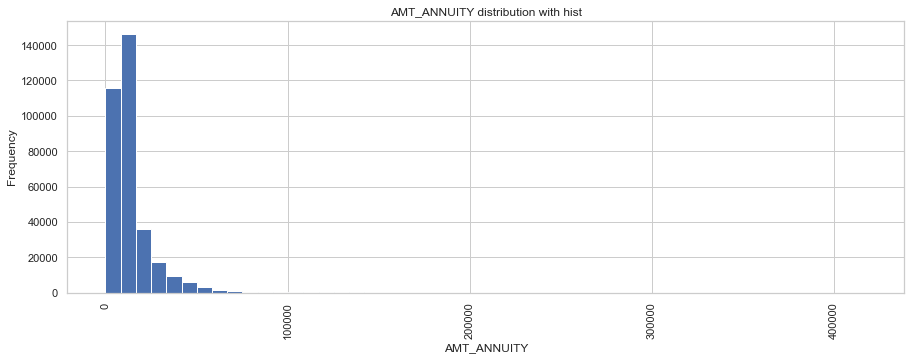

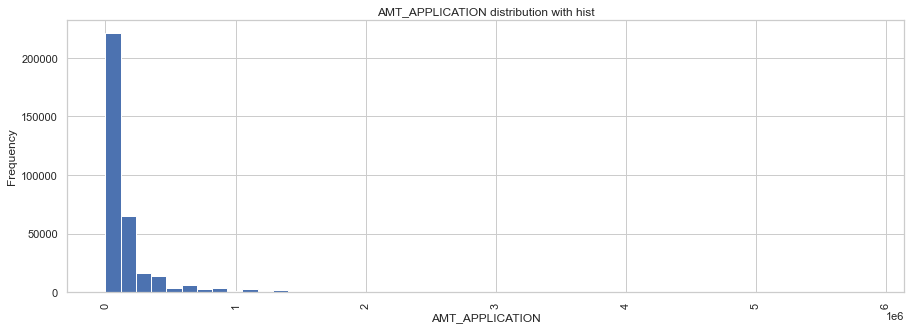

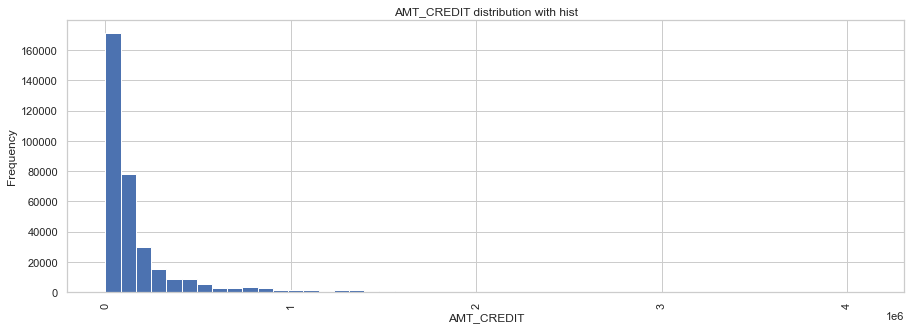

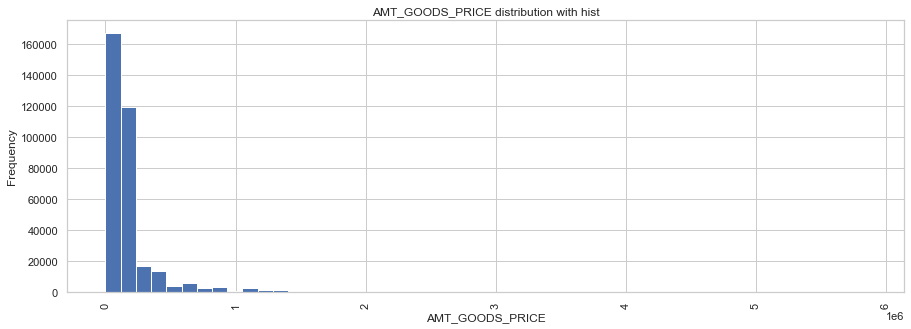

In [77]:
def plot_hist(var):
    plt.figure(figsize=(15,5))
    plt.hist(df[var], bins=50)
    plt.xticks(rotation=90)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(var))
    plt.show()
    
for n in agg_df:
    plot_hist(n)

In [78]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize

In [79]:
minmax_scaler = MinMaxScaler()

agg_df[['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE' ]] = minmax_scaler.fit_transform(agg_df[['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_GOODS_PRICE']])

In [ ]:
def plot_hist(var):
    plt.figure(figsize=(15,5))
    plt.hist(df[var], bins=50)
    plt.xticks(rotation=90)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(var))
    plt.show()
    
for n in agg_df:
    plot_hist(n)

### Load the main dataset

In [80]:
df = pd.read_csv('application_train.csv')

In [81]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
df = df['TARGET']

In [83]:
df = pd.concat([pd.DataFrame(agg_df), df], axis=1)

In [84]:
df

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,TARGET
100001,0.009454,0.004245,0.005796,0.004245,0.0
100002,0.022137,0.030608,0.043626,0.030608,0.0
100003,0.235345,0.153846,0.252386,0.153846,0.0
100004,0.012819,0.004151,0.004899,0.004151,0.0
100005,0.034052,0.000000,0.000000,0.031082,0.0
...,...,...,...,...,...
307409,NaN,NaN,NaN,NaN,0.0
307453,NaN,NaN,NaN,NaN,0.0
307472,NaN,NaN,NaN,NaN,0.0
307487,NaN,NaN,NaN,NaN,0.0


In [86]:
df.isna().sum()

AMT_ANNUITY        110248
AMT_APPLICATION    110248
AMT_CREDIT         110248
AMT_GOODS_PRICE    110248
TARGET             141594
dtype: int64

In [87]:
df_new = df.dropna()

In [88]:
df_new.isna().sum()

AMT_ANNUITY        0
AMT_APPLICATION    0
AMT_CREDIT         0
AMT_GOODS_PRICE    0
TARGET             0
dtype: int64

In [ ]:
# Concatenating scaled and dummy columns

#df_prevoius = pd.concat([pd.DataFrame(agg_df), df], axis=1)

In [ ]:
df_prevoius.shape

In [ ]:
df_previous.info()

In [ ]:
df_prevoius.to_csv(path_or_buf = "previous_application_cleaned.csv", index=False)

### EDA

 checking what % of previous applications was for CASH, POS, CAR, etc -->  Majority of the applications are for POS and then followed by Cash. Least is Cars.¶
"What % of previous applications was for CASH, POS, CAR, etc")
NAME_PORTFOLIO

In [ ]:
#### Dividing the data based on the Contract Status:
''''complete_loan_data_Approved = df[df['NAME_CONTRACT_STATUS'] == 'Approved']
complete_loan_data_Canceled = df[df['NAME_CONTRACT_STATUS'] == 'Canceled']
complete_loan_data_Refused = df[df['NAME_CONTRACT_STATUS'] == 'Refused']
complete_loan_data_Unused = df[df['NAME_CONTRACT_STATUS'] == 'Unused offer']

In [ ]:
'''''def plot3_func(var):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))
    
    s1=sns.countplot(ax=ax1,x=complete_loan_data_Approved[var], data=complete_loan_data_Approved)
    s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
    ax1.set_title("Approved", fontsize=10) 
    ax1.set_xlabel(var)
    ax1.set_ylabel("Count of Loans")    
    
    s2=sns.countplot(ax=ax2,x=complete_loan_data_Canceled[var], data=complete_loan_data_Canceled)
    s2.set_xticklabels(s2.get_xticklabels(),rotation=90)
    ax2.set_title("Canceled", fontsize=10)
    ax2.set_xlabel(var)
    ax2.set_ylabel("Count of Loans")    
    
    s3=sns.countplot(ax=ax3,x=complete_loan_data_Refused[var], data=complete_loan_data_Refused)
    s3.set_xticklabels(s3.get_xticklabels(),rotation=90)
    ax3.set_title("Refused", fontsize=10)
    ax3.set_xlabel(var)
    ax3.set_ylabel("Count of Loans")    
    plt.show()

In [ ]:
#plot3_func('PRODUCT_COMBINATION')


POS household with interest product combination has more number of Approved loans. Whereas Cash product conbination has more no of Canceled loans. And, Cash X-Sell:low sees more no of Refused loans.
<br>
* Focus on clients from housing type ‘House/apartment’ as they are having less paying difficulties.



In [ ]:
''''approved_corr = complete_loan_data_Approved.corr().abs().unstack()
approved_corr = approved_corr[~(approved_corr==1.0)]
round(approved_corr.sort_values(kind='quicksort').drop_duplicates().tail(10).sort_values(ascending=False)*100,2)

In [ ]:
''''canceled_corr = complete_loan_data_Canceled.corr().abs().unstack()
canceled_corr = canceled_corr[~(canceled_corr==1.0)]
canceled_corr.sort_values(kind='quicksort').drop_duplicates().tail(10).sort_values(ascending=False)*100

In [ ]:
''''refused_corr = complete_loan_data_Refused.corr().abs().unstack().dropna()
refused_corr = refused_corr[~(refused_corr==1.0)]
refused_corr.sort_values(kind='quicksort').drop_duplicates().tail(10).sort_values(ascending=False)*100

In [ ]:
''''unused_corr = complete_loan_data_Unused.corr().abs().unstack()
unused_corr = unused_corr[~(unused_corr==1.0)]
unused_corr.sort_values(kind='quicksort').drop_duplicates().tail(10).sort_values(ascending=False)*100

Repeater client type seems to have more number of loans across each Contract status

In [ ]:
## understanding the column meaning & values and checking the datatype for numerical and categorical
for i in df.columns:
    print(df[i].value_counts().head(10),"\n\n")

In [ ]:
df.columns.tolist()

In [ ]:
"""
Since one-hot encoding all of the categorical data in the previous_application frame would create lots of new column, 
so I decided to select some of the feature that I think they should contain more valuable information.
- NAME_CONTRACT_TYPE
- NAME_CONTRACT_STATUS
- NAME_CLIENT_TYPE
- CHANNEL_TYPE
- PRODUCT_COMBINATION